## 「ベイズ推論による機械学習入門」P.128 ポアソン混合モデルにおけるギブスサンプリング

## ポアソン混合モデル

* クラスタkの観測モデルをポアソン分布とする（式1）。
* ポアソン分布のパラメータ $\lambda$ の事前分布をガンマ分布（共役事前分布）とする（式2）。
* 各クラスタの混合比率 $\pi$ はカテゴリ分布のため、事前分布をK次元のディリクレ分布（共役事前分布）とする（式3）。
* K個の観測モデルを各データ点に割り当てる潜在変数Sをカテゴリ分布とする（式4）。
* K個のポアソン分布に対して混合比率 $\pi$ を使って加重平均を取って各データ点に対する確率を求める（式5）。

$$\mathcal{p}(\mathcal{x}_n|\lambda_k) = Poi(\mathcal{x}_n|\lambda_k)\quad (1)$$

$$\mathcal{p}(\lambda_k) = Gam(\lambda_k|a, b)\quad (2)$$

$$\mathcal{p}(\boldsymbol\pi) = Dir(\boldsymbol\pi|\boldsymbol\alpha)\quad (3)$$

$$\mathcal{p}(s_n|\pi) = Cat(s_n|\pi)\quad (4)$$

$$\sum_{k=1}^K \pi_k Poi(x_n|\lambda_k)\quad (5)$$


## 観測モデルの設定

In [1]:
using Distributions
using Plots
using StatsBase

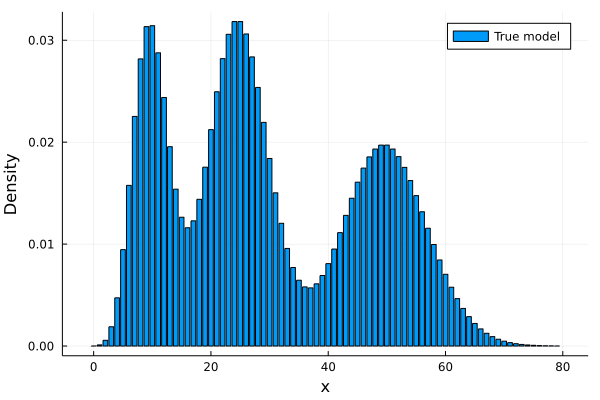

In [2]:
# ポアソン分布のパラメータを設定
𝛌 = [10.0, 25.0, 50.0] # \bflambda + <TAB>
# クラスタ数
K = length(𝛌)
# 混合比率を設定
𝛑 = [0.25, 0.4, 0.35] # \bfpi + <TAB>

# x軸を設定
xs = range(0, step=1, length=80)

# 確率計算、作図
bar(xs, sum(k -> 𝛑[k] * pdf(Poisson(𝛌[k]), xs), 1:K), label="True model", xlabel="x", ylabel="Density")

### Distributions.jiを使うやり方

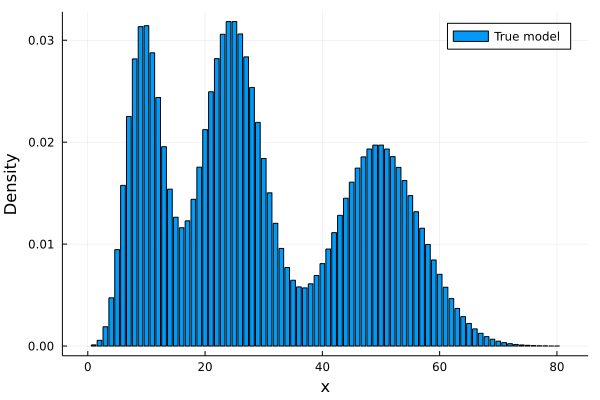

In [3]:
# ポアソン分布のパラメータを設定
𝛌 = [10.0, 25.0, 50.0] # \bflambda + <TAB>
# クラスタ数
K = length(𝛌)
# 混合比率を設定
𝛑 = [0.25, 0.4, 0.35] # \bfpi + <TAB>

# components を true/false によって（\bfpi のウェイトをつけないかつけるかを）コントロールできる
# https://github.com/JuliaPlots/StatsPlots.jl/pull/246
d = MixtureModel([Poisson(λ) for λ in 𝛌], 𝛑)
bins = 80
bar(x->pdf(d, x), 1:80, label="True model", xlabel="x", ylabel="Density")

## データの生成

潜在変数Sを生成し、各データに割り当てられたクラスタに従って観測データXを生成する。

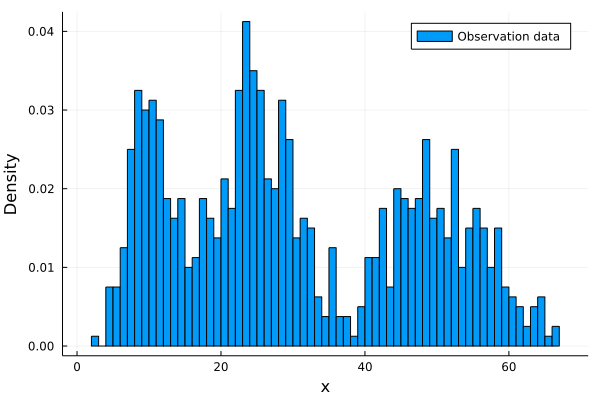

In [20]:
# 観測データ数を設定
N = 800
# 潜在変数を生成
multinomial = Multinomial(1, 𝛑)
𝐒 = rand(multinomial, N) # \bfS + <TAB>
# クラスタ番号を抽出
𝐬 = mapslices(argmax, 𝐒, dims=1) # bfs + <TAB>
# 各データのクラスタに従い観測データを生成
poi_dists = Poisson.(𝛌[𝐬])
X = rand.(poi_dists) |> vec
# 確率計算、作図
histogram(X ;bins, label="Observation data", xlabel="x", ylabel="Density", norm=:pdf)

# # 確率計算、作図(count関数を使うやり方)
#x_prob = zeros(length(xs))
#for x in 1:length(xs)
#    x_prob[x] = count(𝐗 .== x) / length(𝐗)
#end

#bar(xs, x_prob, label="Observation data")
#plot!(xlabel="x", ylabel="Density")

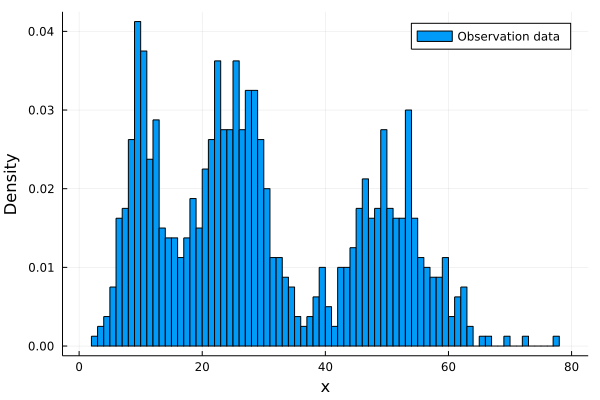

In [6]:
# 別のアプローチ
𝐒 = rand(multinomial, N) # \bfS + <TAB>
𝐬 = mapslices(argmax, 𝐒, dims=1) # bfs + <TAB>

X = Float64[]
for (i, λ) in enumerate(𝛌)
    n = count(𝐬 .== i)
    d = Poisson(λ)
    X = vcat(X, rand(d, n))
end

histogram(X; bins, label="Observation data", xlabel="x", ylabel="Density", norm=:pdf)

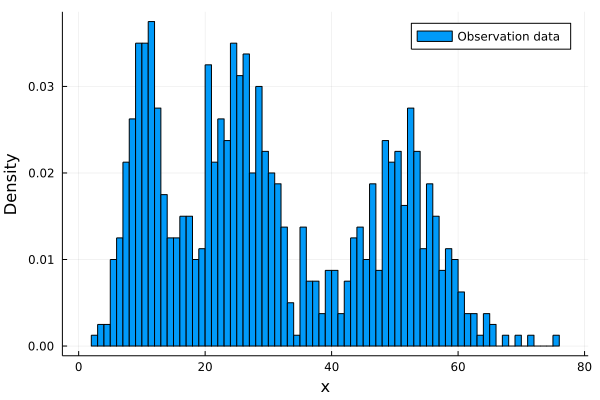

In [7]:
# 別のアプローチ
𝐒 = rand(multinomial, N) # \bfS + <TAB>
𝐬 = mapslices(argmax, 𝐒, dims=1) # bfs + <TAB>

X = Vector{Float64}[[],[],[]] # 配列の配列を作成. 次のセルで活用する
for (i, λ) in enumerate(𝛌)
    n = count(𝐬 .== i)
    d = Poisson(λ)
    X[i]=rand(d,n)
end

histogram(vcat(X...); bins, label="Observation data", xlabel="x", ylabel="Density", norm=:pdf)

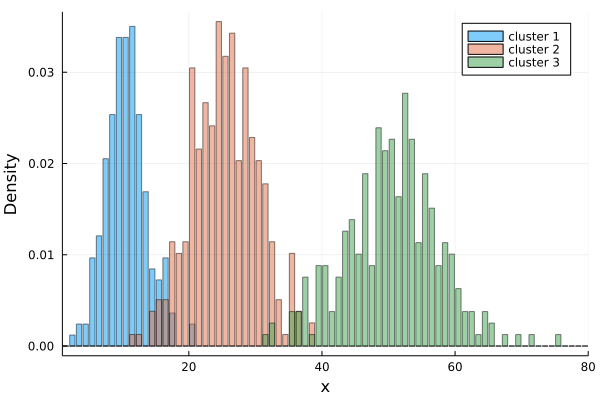

In [8]:
# StatsBase の fit(Histogram, data, bins) を利用する
# https://discourse.julialang.org/t/how-to-bin-data-properly-for-further-study-by-example-to-plot-it-estimated-pdf-and-cdf/26511/8

p = plot(xlabel="x", ylabel="Density", xlim=(1, 80))
for (i, λ) in enumerate(𝛌)
    h = fit(Histogram, X[i], 1:80)
    bar!(p, h.edges, 𝛑[i] * h.weights/length(X[i]), label="cluster $i", alpha=0.5)
end
p

## 事前分布の設定

ポアソン分布のパラメータ $\lambda$ の事前分布としてガンマ分布（共役事前分布）を、各クラスタの混合比率 $\pi$ の事前分布としてディリクレ分布（共役事前分布）を設定する。

$$\mathcal{p}(\lambda_k) = Gam(\lambda_k|a, b)$$

$$\mathcal{p}(\boldsymbol\pi) = Dir(\boldsymbol\pi|\boldsymbol\alpha)$$

$$\quad \boldsymbol\alpha = (\alpha_1, \alpha_2,..., \alpha_K)$$


### $\lambda$ の事前分布

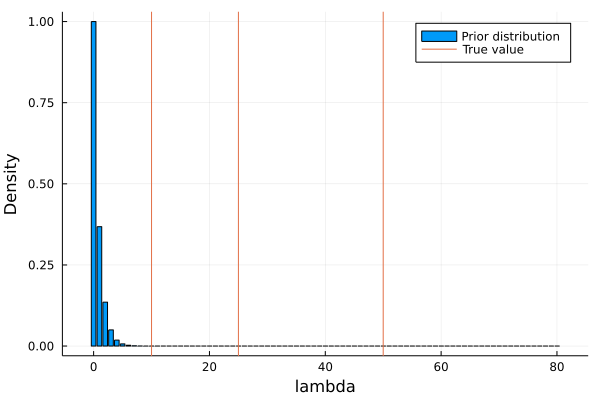

In [13]:
# ガンマ分布のパタメータを設定
a = 1.0
b = 1.0
# ガンマ分布
gamma = Gamma(a, b)

# 確立密度計算、作図
bar(0:80, pdf(gamma, 0:80), label="Prior distribution", xlabel="lambda", ylabel="Density")
plot!([10.0, 25.0, 50.0], seriestype="vline", label="True value")

### $\pi$ の事前分布

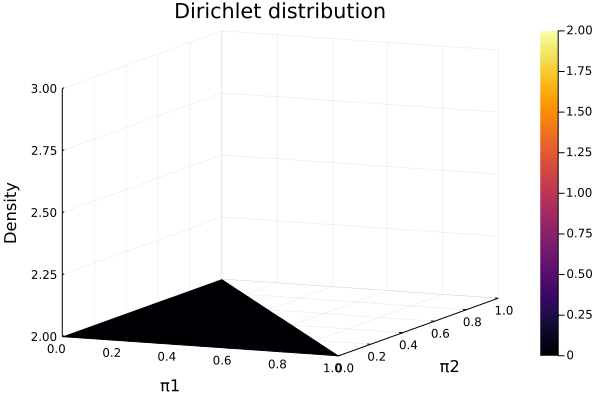

In [15]:
# ディリクレ分布のパタメータ
𝛂 = [1.0, 1.0, 1.0] # \bfalpha + <TAB>

# ディリクレ分布
dirichlet = Dirichlet(𝛂)

# 確率密度計算
π1_array = range(0, 1, length=100)
π2_array = range(0, 1, length=100)
dirichlet_prob = zeros(100, 100)
for (i, π1) in enumerate(π1_array)
    for (j, π2) in enumerate(π2_array)
        π3 = 1 - (π1 + π2)
        if π3 >= 0
            dirichlet_prob[i, j] = pdf(dirichlet, [π1, π2, π3])
        end
    end
end

# 作図
dirichlet_prob[dirichlet_prob .== 0] .= NaN
surface(π1_array, π2_array, dirichlet_prob)
plot!(xlabel="π1", ylabel="π2", zlabel="Density", title="Dirichlet distribution")

## 初期値の生成

事前分布に従って、パラメータ$\lambda$と$\pi$ の初期値を生成し、初期値を用いてモデルの分布を確認する。

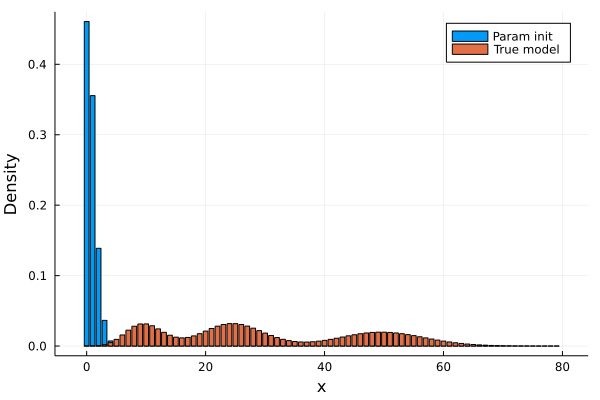

In [25]:
# 事前分布からパラメータの初期値を生成
init_λ = rand(gamma, 3)
init_π = rand(dirichlet, 1)

# 初期値を使って確率計算、作図
xs = range(0, step=1, length=80)
bar(xs, sum(k -> init_π[k] * pdf(Poisson(init_λ[k]), xs), 1:K), label="Param init")
bar!(xs, sum(k -> 𝛑[k] * pdf(Poisson(𝛌[k]), xs), 1:K), label="True model")
plot!(xlabel="x", ylabel="Density")

### ギブスサンプリングの導出

ポアソン混合モデルの事後分布からパラメータをサンプリングするアルゴリズムを導出する。

$\boldsymbol X$が観測された後の条件付き分布は以下になる。

$$\mathcal{p}(\boldsymbol S,\boldsymbol \lambda,\boldsymbol \pi,\boldsymbol X)$$

混合分布では、潜在変数とパラメータを分けてサンプリングすることで、簡単な確率分布が得られることから、以下より潜在変数とパラメータををサンプリングすることとする。

$$\boldsymbol S \sim \mathcal{p}(\boldsymbol S|\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi) $$

$$\boldsymbol \lambda,\boldsymbol \pi \sim \mathcal{p}(\boldsymbol \lambda,\boldsymbol \pi|\boldsymbol X, \boldsymbol S) $$

### 潜在変数$\boldsymbol S$ をサンプリングするための条件分布を求める

\begin{eqnarray}
\mathcal{p}(\boldsymbol S|\boldsymbol X,\boldsymbol \lambda,\boldsymbol \pi) &=& \frac{p(\boldsymbol S,\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi)}{p(\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi)}\\
&\propto& p(\boldsymbol S,\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi)\\
&=& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)p(\boldsymbol \lambda)p(\boldsymbol \pi)\\
&\propto& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)\\
&=& \prod_{n=1}^{N} p(x_n|s_n, \boldsymbol \lambda)p(s_n|\boldsymbol \pi) \\
&=& \prod_{n=1}^{N} \Bigr\{ \prod_{k=1}^{K}Poi(x_n|\lambda_k)^{s_{n,k}}Cat(\boldsymbol s_n|\boldsymbol \pi) \Bigr\}\\
\end{eqnarray}

$\boldsymbol s_n$をサンプリングするための確率分布を計算する。前の項は、

\begin{eqnarray}
\ln \mathcal{p}(x_n|\boldsymbol s_n,\boldsymbol \lambda) &=& \ln \Bigr\{\prod_{n=1}^{N}Poi(x_n|\lambda_k)^{s_{n,k}} \Bigr\} \\
&=& \sum_{k=1}^{K}s_{n,k}\ln Poi (x_n|\lambda_k) \\
&=& \sum_{k=1}^{K}s_{n,k}\ln\frac{\lambda_k^{x_n}}{x_n!}\exp(-\lambda_k)\\
&=& \sum_{k=1}^{K}s_{n,k}(x_n \ln \lambda_k - \ln x_n! - \lambda_k)\\
&=& \sum_{k=1}^{K}s_{n,k} x_n \ln \lambda_k - \sum_{k=1}^{K} \ln s_{n,k}x_n! - \sum_{k=1}^{K} s_{n,k}\lambda_k \\
&=& \sum_{k=1}^{K} s_{n,k}(x_n \ln\lambda_k - \lambda_k) + const. \\
\end{eqnarray}

また、後ろの項は

\begin{eqnarray}
\ln \mathcal{p}(\boldsymbol s_n|\boldsymbol \pi) &=& \ln Cat(\boldsymbol s_n|\boldsymbol \pi)\\
&=& \ln \prod_{k=1}^{K}\pi_k^{s_{n,k}} \\
&=& \sum_{k=1}^{K}s_{n,k}\ln\pi_k \\
\end{eqnarray}

まとめると、

\begin{eqnarray}
\ln \mathcal{p}(s_n|\boldsymbol X, \boldsymbol \lambda, \boldsymbol \pi) &=& \ln \mathcal{p}(x_n|\boldsymbol s_n, \boldsymbol \lambda) + \ln \mathcal{p}(\boldsymbol s_n|\boldsymbol \pi) + const.\\
&=& \sum_{k=1}^{K} s_{n,k}(x_n \ln\lambda_k - \lambda_k) + \sum_{k=1}^{K}s_{n,k}\ln\pi_k + const. \\
&=& \sum_{k=1}^{K}s_{n,k}(x_n\ln\lambda_k - \lambda_k + \ln\pi_k) + const. \\
&=& \sum_{k=1}^{K}s_{n,k}\ln\eta_{n,k} + const. \quad \eta_{n,k} \propto \exp(x_n\ln\lambda_k - \lambda_k + \ln\pi_k) \\
\end{eqnarray}

したがって、$\boldsymbol s_n$の条件付き分布は以下のようになる。

\begin{eqnarray}
\mathcal{p}(s_n|\boldsymbol X, \boldsymbol \lambda, \boldsymbol \pi) &=& \prod_{k=1}^{K} \eta_{n,k}^{s_{n,k}}\\
&=& Cat(\boldsymbol s_n|\boldsymbol \eta_n) \quad \boldsymbol \eta_n =(\eta_{n,1},\eta_{n,2},....,\eta_{n,K}) \quad (1) \\
\end{eqnarray}


### 潜在変数Sのサンプリングの実装

In [69]:
η = exp.(X * log.(init_λ') .- init_λ' .+ init_π')
norm_η = η ./ sum(η, dims=2)
categorical = Categorical(norm_η[1,:])
pdf(categorical, 1:3)

3-element Array{Float64,1}:
 0.0038491840855571302
 0.0021222522760299877
 0.994028563638413

### $\boldsymbol \lambda$と$\boldsymbol \pi$をサンプリングするための条件分布を求める

\begin{eqnarray}
\mathcal{p}(\boldsymbol \lambda,\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \frac{p(\boldsymbol X, \boldsymbol S,\boldsymbol \lambda,\boldsymbol \pi)}{p(\boldsymbol X, \boldsymbol S)}\\
&\propto& p(\boldsymbol X, \boldsymbol S,\boldsymbol \lambda,\boldsymbol \pi)\\
&=& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)p(\boldsymbol \lambda)p(\boldsymbol \pi)\\
\end{eqnarray}

また、左辺の条件付き分布を分解し、以下のように変形する。

\begin{eqnarray}
\mathcal{p}(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S)\mathcal{p}(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)p(\boldsymbol \lambda)p(\boldsymbol \pi)\\
\end{eqnarray}

はじめに$\boldsymbol \lambda$をサンプリングするための条件分布を求める。

\begin{eqnarray}
\mathcal{p}(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \frac{\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)\mathcal{p}(\boldsymbol S|\boldsymbol \pi)\mathcal{p}(\boldsymbol \lambda)\mathcal{p}(\boldsymbol \pi)}{\mathcal{p}(\boldsymbol \pi|\boldsymbol X, \boldsymbol S)}\\
\ln p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \ln p(\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda) + \ln p(\boldsymbol S|\boldsymbol \pi) + \ln p(\boldsymbol \lambda) + \ln p(\boldsymbol \pi) - \ln p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S)\\
&=& \ln p(\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda) + \ln p(\boldsymbol \lambda) + const.\\
&=& \sum_{n=1}^{N}\sum_{k=1}^{K}s_{n,k}\ln Poi(x_n|\lambda_k) + \sum_{k=1}^{K}\ln Gam(\lambda_k|a,b)\\
&=& \sum_{k=1}^{K}\Bigr\{\sum_{n=1}^{N}s_{n,k}\ln \frac{\lambda_k^{x_n}}{x_n!}\exp(-\lambda_k) + \ln C_G(a,b)\lambda_k^{a-1}\exp(-b\lambda_k)\Bigr\}\\
&=& \sum_{k=1}^{K} \Bigr\{\sum_{n=1}^{N}s_{n,k}(x_n \ln x_n - \ln x_n! - \lambda_k) + \ln C_G(a,b) + (a-1)\ln \lambda_k - b \lambda_k \Bigr\} + const.\\
&=& \sum_{k=1}^{K} \Bigr\{(\sum_{n=1}^{N}s_{n,k}x_n + a - 1)\ln \lambda_k - (\sum_{n=1}^{N}s_{n,k} + b)\lambda_k \Bigr\} + const.\\
\end{eqnarray}

$\hat{a}_k$、$\hat{b}_k$を以下とすると、

$$\hat{a}_k = \sum_{n=1}^{N}s_{n,k}x_n + a$$
$$\hat{b}_k = \sum_{n=1}^{N}s_{n,k} + b$$

\begin{eqnarray}
\ln p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \sum_{k=1}^{K}\Bigr\{(\hat{a}_k - 1) \ln \lambda_k - \hat{b}_k \lambda_k \Bigr\} + const.\\
p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \prod_{k=1}^{K} C_G(\hat{a}_k,\hat{b}_k)\lambda_k^{\hat{a}_k-1}\exp(-\hat{b}_k\lambda_k)\\
&=& \prod_{k=1}^{K} Gam(\lambda_k|\hat{a}_k,\hat{b}_k) \quad (2)\\
\end{eqnarray}

したがって、$\boldsymbol \lambda$の条件分布は$\hat{a}_k$、$\hat{b}_k$をパラメータに持つガンマ分布になる。

### パラメータ$\lambda$のサンプリングの実装

In [ ]:
â = sum()
#b̂

次に$\boldsymbol \pi$をサンプリングするための条件分布を求める。

\begin{eqnarray}
\mathcal{p}(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \frac{\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)\mathcal{p}(\boldsymbol S|\boldsymbol \pi)\mathcal{p}(\boldsymbol \lambda)\mathcal{p}(\boldsymbol \pi)}{\mathcal{p}(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S)}\\
\ln p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \ln p(\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda) + \ln p(\boldsymbol S|\boldsymbol \pi) + \ln p(\boldsymbol \lambda) + \ln p(\boldsymbol \pi) - \ln p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S)\\
&=& \ln p(\boldsymbol S|\boldsymbol \pi) + \ln p(\boldsymbol \pi) + const. \\
&=& \sum_{n=1}^{N}\ln Cat(s_n|\boldsymbol \pi) + \ln Dir(\boldsymbol \pi|\boldsymbol \alpha)\\
&=& \sum_{n=1}^{N}\ln \prod_{k=1}^{K} \pi_k^{s_{n,k}} + \ln C_D(\boldsymbol \alpha) \prod_{k=1}^{K}\pi_k^{\alpha_k - 1} + const.\\
&=& \sum_{n=1}^{N}\sum_{k=1}^{K}s_{n,k}\ln\pi_k + \ln C_D(\boldsymbol \alpha) + \sum_{k=1}^{K}(\alpha_k - 1)\ln \pi_k + const. \\
&=& \sum_{k=1}^{K}(\sum_{n=1}^{N}s_{n,k} + \alpha_k - 1)\ln \pi_k + const.\\
\end{eqnarray}


$\hat{\alpha}_k$を以下とすると、

$$\hat{\alpha}_k = \sum_{n=1}^{N}s_{n,k} + \alpha_k$$

\begin{eqnarray}
\ln p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \sum_{k=1}^{K}(\hat{\alpha}_k - 1)\ln \pi_k + const.\\
p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& C_D(\boldsymbol \alpha)\prod_{k=1}^{K}\pi_k^{\hat{\alpha}_k - 1}\\
&=& Dir(\boldsymbol \pi|\hat{\boldsymbol \alpha}) \quad\ \hat{\boldsymbol \alpha} = (\hat{\alpha}_1,\hat{\alpha}_2,...,\hat{\alpha}_K) \quad (3)\\
\end{eqnarray}

したがって、$\boldsymbol \pi$の条件分布は$\hat{\boldsymbol \alpha}$をパラメータに持つディリクレ分布になる。

### パラメータ$\pi$のサンプリングの実装